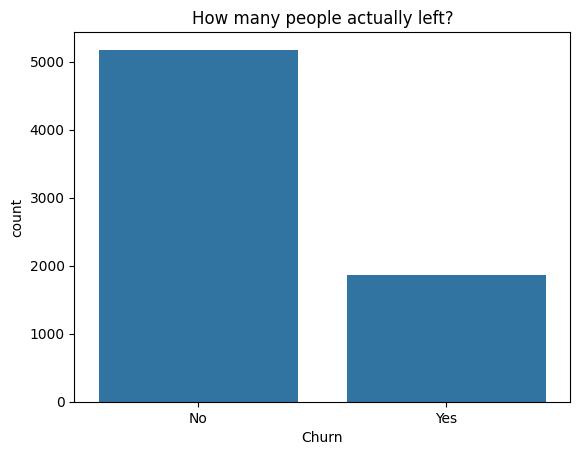

Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load data
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

# 2. Fix TotalCharges (it's loaded as text, needs to be numbers)
# errors='coerce' turns empty strings into NaN (missing values)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# 3. Fill the new NaNs with 0
df['TotalCharges'] = df['TotalCharges'].fillna(0)

# 4. Check the Churn distribution
sns.countplot(x='Churn', data=df)
plt.title("How many people actually left?")
plt.show()

print(df['Churn'].value_counts(normalize=True))

In [2]:
# 1. Install XGBoost (if you haven't already)
# (Run this line once in your terminal or cell)
# !pip install xgboost

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# 2. Drop the ID column (useless for prediction)
df = df.drop('customerID', axis=1)

# 3. Target Encoding (Churn: Yes -> 1, No -> 0)
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# 4. Feature Encoding (One-Hot Encoding for text columns like 'Contract', 'PaymentMethod')
# drop_first=True prevents redundancy (e.g., we don't need both "Male" and "Female" columns)
df = pd.get_dummies(df, drop_first=True)

# 5. Split Data
X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 6. Train the XGBoost Model
# use_label_encoder=False removes a warning message
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# 7. Predict
predictions = model.predict(X_test)

# 8. Score
print("Accuracy:", accuracy_score(y_test, predictions))
print("\nClassification Report:\n", classification_report(y_test, predictions))

Accuracy: 0.7913413768630234

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.89      0.86      1036
           1       0.63      0.52      0.57       373

    accuracy                           0.79      1409
   macro avg       0.73      0.71      0.72      1409
weighted avg       0.78      0.79      0.78      1409



c:\Users\Waleed\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:53:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [5]:
# Calculate the ratio for the weight
# (Count of Negative Class / Count of Positive Class)
# In this dataset, it's roughly 3 (73% / 26%)
weight = (y_train == 0).sum() / (y_train == 1).sum()

# Re-train with the weight parameter
model_weighted = XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=weight)
model_weighted.fit(X_train, y_train)

# Predict again
predictions_weighted = model_weighted.predict(X_test)

print("--- Weighted XGBoost Results ---")
print("Recall for Churn (1):")
print(classification_report(y_test, predictions_weighted))

--- Weighted XGBoost Results ---
Recall for Churn (1):
              precision    recall  f1-score   support

           0       0.88      0.81      0.84      1036
           1       0.56      0.70      0.62       373

    accuracy                           0.78      1409
   macro avg       0.72      0.75      0.73      1409
weighted avg       0.80      0.78      0.78      1409



c:\Users\Waleed\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:199: UserWarning: [15:05:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


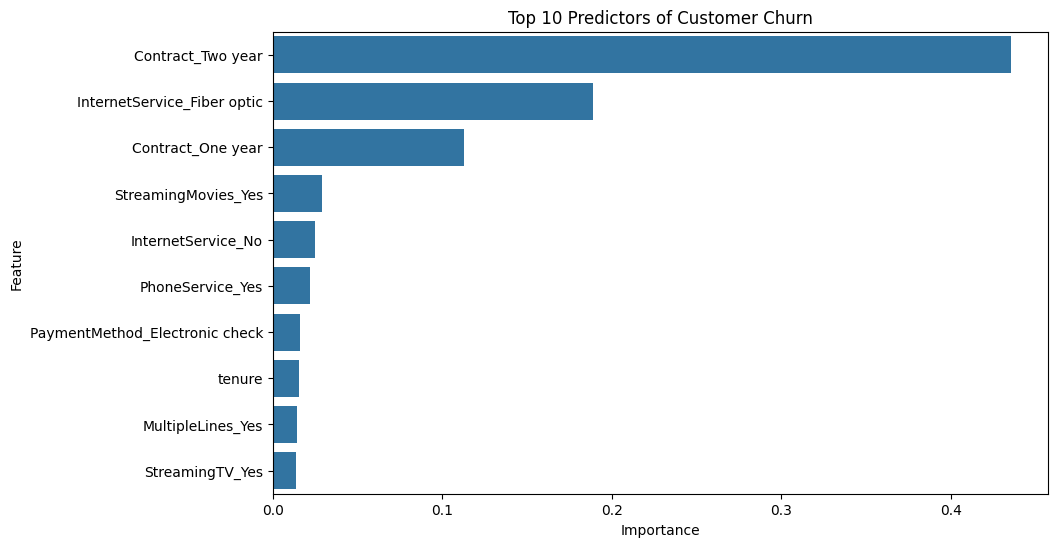

In [6]:
# Get feature importances
importances = model_weighted.feature_importances_

# Create a DataFrame to view them
feature_imp = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot the Top 10 reasons people leave
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_imp.head(10))
plt.title("Top 10 Predictors of Customer Churn")
plt.show()

In [7]:
import numpy as np

# 1. Get the real answers (y_test) and our predictions
actual_churn = y_test
predicted_churn = predictions_weighted

# 2. define costs
cost_of_losing_customer = 500
cost_of_retention_offer = 50

# 3. Calculate the scenarios
# True Positive (TP): We predicted they'd leave, and they were going to. We send offer, they stay.
# Cost: $50 (offer) | Savings: $500 (kept customer) | Net: +$450
tp = np.sum((actual_churn == 1) & (predicted_churn == 1))

# False Positive (FP): We predicted they'd leave, but they were happy.
# Cost: $50 (wasted offer) | Savings: $0
fp = np.sum((actual_churn == 0) & (predicted_churn == 1))

# False Negative (FN): We predicted they'd stay, but they left.
# Cost: $500 (lost customer)
fn = np.sum((actual_churn == 1) & (predicted_churn == 0))

# 4. Total Savings vs Doing Nothing
total_savings = (tp * (cost_of_losing_customer - cost_of_retention_offer)) - (fp * cost_of_retention_offer)

print(f"By using this model, we saved the company: ${total_savings:,.0f}")
print(f"Customers Saved: {tp}")
print(f"Money Wasted on Happy Customers: ${fp * cost_of_retention_offer:,.0f}")

By using this model, we saved the company: $106,900
Customers Saved: 260
Money Wasted on Happy Customers: $10,100
